In [97]:
import pygraphviz as pgv
from IPython.display import Image
import pandas as pd, numpy as np
from sklearn.tree import DecisionTreeRegressor # Import Decision Tree Regressor
from sklearn.tree import export_graphviz
import matplotlib.pyplot as plt

# Introduction

Having selected the variables to use in the BN after analysis in notebooks 03-04, in this notebook we:
- Just pick the variables of interest
- Fill any NaNs it is reasonable to fill
- Write them to csv
- Discretize the variables and write to another csv

To discretize, use two methods:

1) Regression tree analysis to determine break points<br>
2) Simple terciles

# Read in data

In [98]:
# Read in data. This is output from notebook B
fpath = r'../../data/DataMatrices/VansjøData_%s_forBN.csv'

# Season list
season_li = ['summ','aut']

df_dict = {}
for season in season_li:
    infile = fpath %season
    df_dict[season] = pd.read_csv(infile, index_col = 0)

In [99]:
df_dict['summ'].head()

,chla,chla_prevSummer,colour,colour_prevSummer,cyano,cyano_prevSummer,rain,rain_lag1,rainy_days_winter,temp,TP,TP_prevSummer,windDays_under_Q0.4,windDays_over_Q0.6
year,,,,,,,,,,,,,,
1980,12.169127,NaN,NaN,NaN,NaN,NaN,242.199218,80.992741,NaN,14.449403,36.084127,NaN,43.0,27.0
1981,7.075000,16.471230,NaN,NaN,NaN,NaN,282.257779,105.457323,102.0,13.213264,23.583333,43.573016,28.0,43.0
1982,5.466667,8.331250,NaN,NaN,NaN,NaN,151.006233,175.810938,105.0,13.452291,37.777778,28.833333,25.0,41.0
1983,5.980000,5.847917,19.4,26.666667,NaN,NaN,182.728817,122.882007,121.0,13.517998,31.960000,28.336806,23.0,51.0
1984,10.230000,6.073333,NaN,17.033333,NaN,NaN,255.820629,74.093285,121.0,13.845605,27.360000,29.055000,17.0,51.0


In [100]:
df_dict['aut'].head()

,chla,chla_lag1,chla_prevSummer,colour,colour_lag1,colour_prevSummer,cyano,cyano_lag1,cyano_prevSummer,rain,rain_lag1,rainy_days_winter,temp,TP,TP_lag1,TP_prevSummer,windDays_under_Q0.4,windDays_over_Q0.6
year,,,,,,,,,,,,,,,,,,
1980,20.773333,12.169127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,351.676639,242.199218,NaN,9.575229,51.061905,36.084127,NaN,38.0,33.0
1981,9.587500,7.075000,16.471230,NaN,NaN,NaN,NaN,NaN,NaN,216.851554,282.257779,102.0,9.937926,34.083333,23.583333,43.573016,41.0,29.0
1982,6.229167,5.466667,8.331250,26.666667,NaN,NaN,NaN,NaN,NaN,297.668159,151.006233,105.0,10.870945,18.895833,37.777778,28.833333,28.0,47.0
1983,6.166667,5.980000,5.847917,14.666667,19.4,26.666667,NaN,NaN,NaN,275.606690,182.728817,121.0,10.877162,26.150000,31.960000,28.336806,25.0,51.0
1984,11.950000,10.230000,6.073333,NaN,NaN,17.033333,NaN,NaN,NaN,317.230629,255.820629,121.0,10.635043,25.695000,27.360000,29.055000,35.0,31.0


# Merge seasons, fill NaNs and export continuous df

- Drop variables that definitely won't be used in the BN. Note, some other vars may be dropped at a later stage, after x-val of different network structures
- Merge the two seasons into one dataframe, with independently named variables
- Fill NaNs where appropriate

In [101]:
# USER INPUT

# Variables to drop that definitely won't be used in the BN, by season
drop_vars_dict = {
                  'summ': ['rain_lag1', 'windDays_under_Q0.4', 'windDays_over_Q0.6', 'temp'],
                  'aut': ['TP_lag1', 'rain', 'chla_prevSummer',  'colour_prevSummer', 'cyano_prevSummer', 'rainy_days_winter']
                 }

# For variables in this list, add suffix _ES or _LS for early and late summer
suffix_li = ['chla','colour','cyano','TP','rain'] #  N.B. includes more variables for late summer, added in loop below
suffix_dict = {'summ':'_ES', 'aut':'_LS'}


# PROCESSING
df_li = []
# Start renaming and dropping
for season in season_li:
    df = df_dict[season]
    for col in df.columns:
        if col in drop_vars_dict[season]:
            df.drop(col, axis=1, inplace=True)
        
        if season == 'aut':
            suffix_li += ['temp','windDays_under_Q0.4', 'windDays_over_Q0.6']
        if col in suffix_li and col not in drop_vars_dict[season]:
            df[col+'%s' %suffix_dict[season]] = df[col]
            df.drop(col, axis=1, inplace=True)

        # Replace anything ending with '_lag1' with '_ES'
        # There should only be _lag1 vars for late summer
        if season == 'aut':
            if col[-5:] == '_lag1' and col not in drop_vars_dict[season]:
                df[col[:-5]+'_ES'] = df[col]
                df.drop(col, axis=1, inplace=True)
    df_li.append(df)

# Join the early and late summer dataframes into one and drop duplicated columns (e.g. early summer TP, chla, etc. are in both dfs)
cont_df = pd.concat(df_li, axis=1)
cont_df = cont_df.loc[:,~cont_df.columns.duplicated()]

sorted(cont_df.columns)

['TP_ES',
 'TP_LS',
 'TP_prevSummer',
 'chla_ES',
 'chla_LS',
 'chla_prevSummer',
 'colour_ES',
 'colour_LS',
 'colour_prevSummer',
 'cyano_ES',
 'cyano_LS',
 'cyano_prevSummer',
 'rain_ES',
 'rainy_days_winter',
 'temp_LS',
 'windDays_over_Q0.6_LS',
 'windDays_under_Q0.4_LS']

## Filling NaNs

Currently the data cover the period 1980-2018, but with the following gaps:
- Quite a few gaps in colour. But aren't currently using this in the BN, so **drop all colour-related columns**
- All cols 'prevSummer' are missing data in 1980. Therefore: **drop 1980**
- No TP or chl-a data was collected in 1999, so cols TP_LS, TP_ES, chla_ES, chla_LS for then are blanks: for now, **linearly interpolate**. Could also just drop these rows.
- Correspondingly, blanks in TP_prevSummer and chla_prevSummer for 2000. Again, **linearly interpolate**.
- Patchy data from 2017 onwards:
    * 2017: No TP data
    * 2018: need to update TP, chl-a, wind, late summer cyano
  For now, decide to **drop 2018** and **forward fill 2017 TP with 2016**. But (after 2019 project meeting?) need to **update all data**, hopefully to include summer 2019 when there were blooms.
  

- cyanobacteria:
    * if cyano_prevSummer is included as predictor variable, then first year is 1997 and **drop all before**
    * otherwise, first year is 1996, drop all before.
    * Last year is 2017. **Drop 2018**

In [102]:
# Drop colour-related cols
cont_df = cont_df.drop(['colour_ES','colour_LS','colour_prevSummer'], axis=1)

# Truncate start and end years so covers period 1981-2017 (incl.)
cont_df = cont_df.loc[1981:2017,:]

# Linearly interpolate gaps of size 1 and forward fill 2017 TP
cont_df.interpolate(method='linear',limit=1, inplace=True)

In [103]:
# Select variables involved in cyanobacterial BN
cont_df_cyano = cont_df.loc[:,['chla_ES',
                             'chla_LS',
                             'cyano_ES',
                             'cyano_LS',
                             'cyano_prevSummer',
#                              'temp_LS',
                             'windDays_under_Q0.4_LS']]

# Truncate cyanobacteria df to drop missing data from start
cont_df_cyano = cont_df_cyano.loc[1997:,:]

# Check for NaNs
print('Number of NaNs: %s' %cont_df_cyano.isna().sum().sum())

Number of NaNs: 0


In [104]:
# Drop cyanobacteria variables from TP and chl-a dataframe
cont_df_noCyano = cont_df.drop(['cyano_ES',
                                'cyano_LS',
                                'cyano_prevSummer'], axis=1)

# Check for NaNs
print('Number of NaNs: %s' %cont_df_noCyano.isna().sum().sum())

Number of NaNs: 0


## Save the new continuous dataframes

In [105]:
cont_df.to_csv(r'../../data/DataMatrices/Vansjo_Seasonal_Continuous_all.csv')
cont_df_cyano.to_csv(r'../../data/DataMatrices/Vansjo_Seasonal_Continuous_cyano.csv')
cont_df_noCyano.to_csv(r'../../data/DataMatrices/Vansjo_Seasonal_Continuous_noCyano.csv')

# Regression trees to help decide on class boundaries

**No longer working, need to re-do variable names...**

In [106]:
# Dictionary of explanatory variables linked to each response variable, for each season
xy_dict = {'summ':
              {'TP': ['TP_prevSummer'],
               'colour': ['colour_prevSummer','rain'],
               'chla': ['TP','chla_prevSummer', 'rainy_days_winter'],
               'cyano': ['chla','colour', 'cyano_prevSummer']},
           
           'aut':
              {'TP': ['TP_prevSummer'],
               'colour': ['colour_lag1','rain_lag1'],
               'chla': ['windDays_over_Q0.6','TP','chla_lag1'],
               'cyano': ['chla','colour','windDays_under_Q0.4', 'temp', 'cyano_lag1']}
          }  

In [107]:
# # Regression tree, one for each dependent variable, including all possible explanatory variables in one tree
# for season in season_li:
#     for var in xy_dict[season].keys():
#         temp_df = df_dict[season][[var]+xy_dict[season][var]].dropna()
#         y = temp_df[var] # Target variable
#         X = temp_df[xy_dict[season][var]] # Feature(s)
#         regressor = DecisionTreeRegressor(random_state=0,
#                                           max_depth=4,
#                                           min_samples_split=6,
#                                           min_samples_leaf=3,
#                                           max_leaf_nodes=8
#                                          )
#         regressor.fit(X,y)

#         # export the decision tree to a tree.dot file for visualizing the plot easily anywhere
#         dot_fpath = r'../Figures/Discretization_regTrees/AllVarsTogether/DotFiles/%s_%s.dot' %(season,var)
#         export_graphviz(regressor, out_file =dot_fpath, 
#                         feature_names = xy_dict[season][var])

#         # Convert .dot file to .png
#         png_fpath = r'../Figures/Discretization_regTrees/AllVarsTogether/%s_%s.png' %(season,var)
#         pgv.AGraph(dot_fpath).draw(png_fpath, format='png', prog='dot')

In [108]:
# # Regression tree, one for each pair of explanatory - dependent variable
# for season in season_li:
#     for targetvar in xy_dict[season].keys():
#         for xvar in xy_dict[season][targetvar]:
#             temp_df = df_dict[season][[targetvar]+[xvar]].dropna()
#             y = temp_df[targetvar].values # Target variable data
#             y = y.reshape(-1, 1)
#             X = temp_df[xvar].values # Explanatory var data
#             X = X.reshape(-1,1)
#             regressor = DecisionTreeRegressor(random_state=0,
#                                           max_depth=4,
#                                           min_samples_split=6,
#                                           min_samples_leaf=3,
#                                           max_leaf_nodes=8
#                                          )
#             regressor.fit(X,y)

#             # export the decision tree to a tree.dot file for visualizing the plot easily anywhere
#             dot_fpath = r'../Figures/Discretization_regTrees/Pairwise/DotFiles/%s_%s-%s.dot' %(season,targetvar,xvar)
#             export_graphviz(regressor, out_file =dot_fpath, 
#                             feature_names = [xvar])

#             # Convert .dot file to .png
#             png_fpath = r'../Figures/Discretization_regTrees/Pairwise/%s_%s-%s.png' %(season,targetvar,xvar)
#             pgv.AGraph(dot_fpath).draw(png_fpath, format='png', prog='dot')

# Class boundaries

## Based on regression tree analysis and WFD class boundaries

Pick class boundaries from examination of regression trees and scatter plots, and for each variable plot where they lie to see how many data points we will have in each class (not considering joint classes for now)

Notes for particular variables:
TP: WFD class boundaries are 20.0 and 39.0 ug/l. However, pretty much all data are within the 'moderate' class between these two bounds, leading to no data issues when we try to link TP to other nodes. So reduce to just two categories, above or below the midpoint of the 'Moderate' ecological status class.

In [114]:
bound_dict = {
             'TP_ES': [29.5], # No data below 20, so drop this class boundary
             'TP_LS': [29.5],
             'TP_prevSummer': [26.4, 31.5],
             'chla_ES': [10.5, 20.0],
             'chla_LS': [10.5, 20.0],
             'chla_prevSummer': [16.8],
#              'colour_ES': [27.9, 49.6],
#              'colour_LS': [27.9, 49.6],
#              'colour_prevSummer': [26.9, 36.5, 60.4],
             'cyano_ES': [1.0, 2.0],
             'cyano_LS': [1.0, 2.0],
             'cyano_prevSummer': [0.531],
             'rain_ES': [220],
             'rainy_days_winter': [144],
             'temp_LS': [10.9],
             'windDays_over_Q0.6_LS': [33.5],
             'windDays_under_Q0.4_LS': [43.5]
            }

# Previous boundaries used:
#              'TP_ES': [29.5, 39.0], # No data below 20, so drop this class boundary
#              'TP_LS': [20.0, 29.5, 39.0],

In [110]:
# Dropped colour data for now, so this cell commented out.

# # For colour, don't have WFD class boundaries that we're interested in. Instead, just define using terciles for starters
# all_colour_data = pd.concat([cont_df['colour_ES'], cont_df['colour_LS']])

# for q in [0.33, 0.66]:
#     print('Q: %s' %all_colour_data.quantile(q))

## Using terciles

In [124]:
bound_dict_terciles = {}

for var in cont_df.columns:
    bound_dict_terciles[var] = [cont_df[var].quantile(0.333), cont_df[var].quantile(0.667)]

bound_dict_terciles

{'chla_prevSummer': [12.677744444444441, 17.96943333333334],
 'cyano_prevSummer': [0.22652991193857147, 1.3148341321333334],
 'rainy_days_winter': [134.988, 147.012],
 'TP_prevSummer': [28.32881388888889, 32.140566666666665],
 'chla_ES': [11.641133333333334, 17.107661538461535],
 'cyano_ES': [0.13908323017578572, 0.7708633333333336],
 'rain_ES': [185.74809274180396, 248.40200788134393],
 'TP_ES': [27.352080000000008, 31.2016],
 'chla_LS': [13.00614666666667, 18.68866666666667],
 'cyano_LS': [0.2635223647780001, 1.1876963489933339],
 'temp_LS': [10.209550679575301, 11.093509765828909],
 'TP_LS': [26.41566666666667, 31.584333333333326],
 'windDays_under_Q0.4_LS': [35.988, 41.012],
 'windDays_over_Q0.6_LS': [31.0, 35.012]}

## Visualise proportion of data in each class

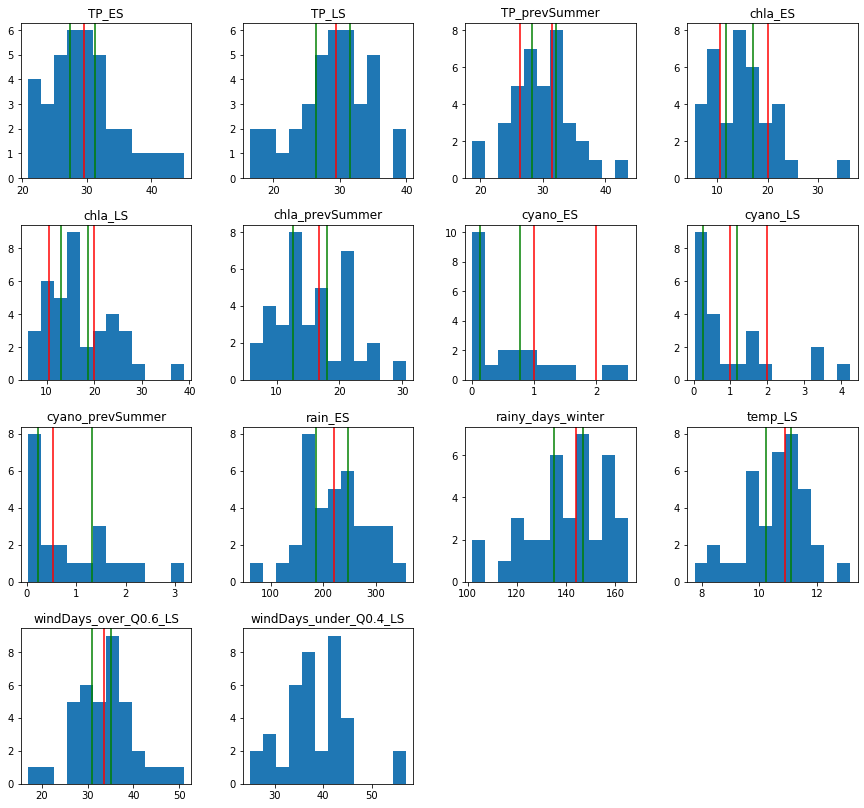

In [125]:
axes = cont_df.hist(bins=12, figsize=(15,14), grid=False)

# For each subplot, add on vertical lines for the proposed class boundaries
# N.B. assumes order of plots is the same as the order of keys in bound_dict
var_li = sorted(list(bound_dict.keys()))

for i, ax in enumerate(axes.flatten()):
    if i<13:
        lines = bound_dict[var_li[i]]
        for line in lines:
            ax.axvline(x=line, color='r')
        tercile_lines = bound_dict_terciles[var_li[i]]
        for tercLine in tercile_lines:
            ax.axvline(x=tercLine, color='g')

plt.show()

# Produce discretized dataframes

In [126]:
def discretize(thresholds, value):
    
    if np.isnan(value):
        return np.NaN
    
    factor_li_dict = {2: ['L','H'],
                     3: ['L','M','H'],
                     4: ['VL','L','M','H'],
                     5: ['VL','L','M','H','VH']}
    
    n_classes = len(thresholds)+1
    
    for i, boundary in enumerate(thresholds):
    
        if value<boundary:
            return factor_li_dict[n_classes][i]
            break # Break out of loop
        
        # If we're up to the last class boundary, and the value is bigger than it, value is in the uppermost class
        if i+1 == len(thresholds) and value >= boundary:
            return factor_li_dict[n_classes][i+1]


## Using regression tree boundaries

In [127]:
cont_df_li = [cont_df, cont_df_cyano, cont_df_noCyano]
fname_suffix_li = ['all','cyano','noCyano']

# Dictionary for storing different discretized dfs.
# Key: data included (all data, or just cyano-related vars, or no cyano vars; from fname_suffix_li). Returns regression-tree df
disc_rt_dict = {}

for i, df in enumerate(cont_df_li):

    # Create empty dataframe to be populated with discretized data
    disc_df = pd.DataFrame(index=df.index, columns=df.columns)

    for var in df.columns:
        disc_df[var] = df[var].apply(lambda x: discretize(bound_dict[var], x))
    
    # Store in dictionary
    disc_rt_dict[fname_suffix_li[i]] = disc_df
        
    # Write to csv
    fname = r'../../data/DataMatrices/Vansjo_Seasonal_Discretized_RegTree_%s.csv' %fname_suffix_li[i]
    disc_df.to_csv(fname)

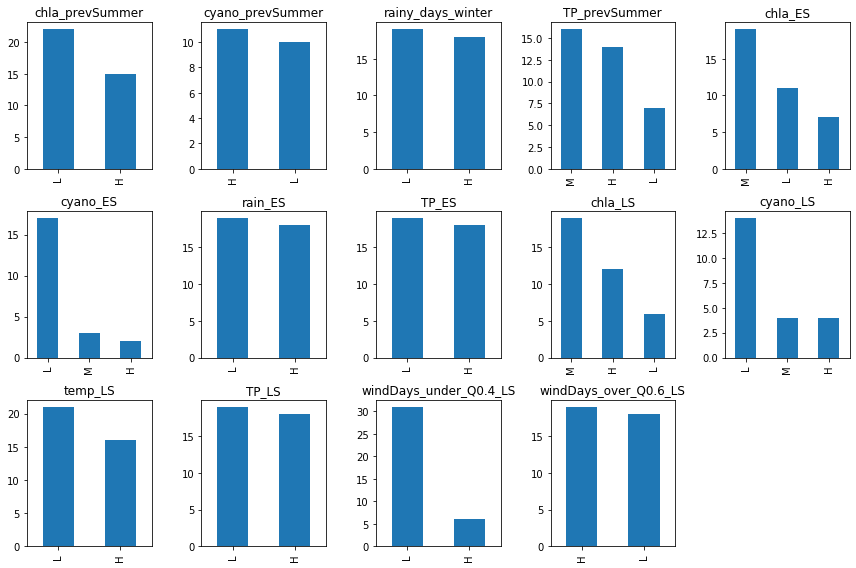

In [130]:
# How balanced are the classes?
disc_df = disc_rt_dict['all']

fig, ax = plt.subplots(3,5, figsize=(12,8))
ax = ax.flatten()
for i, categorical_feature in enumerate(disc_df.columns):
    disc_df[categorical_feature].value_counts().plot(kind="bar", ax=ax[i]).set_title(categorical_feature)

for axi in ax[-1:]:
    fig.delaxes(axi)
plt.tight_layout()

## Discretize using terciles

**To do:** Haven't split this out into different dataframes acccording to whether cyanobacteria-related or not yet

In [ ]:
# Create empty dataframe to be populated with discretized data using terciles
disc_df_terc = pd.DataFrame(index=cont_df.index, columns=cont_df.columns)

for var in cont_df.columns:
    disc_df_terc[var] = cont_df[var].apply(lambda x: discretize(bound_dict_terciles[var], x))

disc_df_terc.to_csv(r'../../data/DataMatrices/Vansjo_Seasonal_Discretized_Terciles.csv')

disc_df_terc.tail(10)

# Continuous data: transforming to make it more Gaussian

It could be good for the BN to be continuous rather than discrete, but BNLearn assumes all nodes are Gaussian. From a look at the histograms above most aren't far off bell-shaped, aside from colour and cyanobacteria. We could just drop all the colour variables from this BN and put it into its own BN. For cyanobacteria, the distribution is right-skewed and has lots of zeros. In reality these won't really be zeros, just below the counting detection limit. So some kind of transformation is required which can cope with zeros.

First, try square rooting.

## Exploring different transformations

In [ ]:
# Original data
cont_df['cyano_ES'].hist(bins=15)

In [ ]:
np.sqrt(cont_df['cyano_ES']).hist(bins=15)

In [ ]:
# Try box cox, y* = (y^l - 1)/L, where L != 0. L close to 0 is a near-logorithmic transformation

from scipy.stats import boxcox
bs = boxcox(cont_df['cyano_ES'].values, lmbda=0.1)

trans_df = pd.DataFrame(index = cont_df.index)
trans_df['original'] = cont_df['cyano_ES']
trans_df['boxcox'] = bs

trans_df['boxcox'].hist(bins=5)

lambda (L) between 0.06 and 0.2 produces symmetrical data. Doesn't look  bell shaped (in fact looks bimodal), but that could easily be because of the low n. No reason to pick any particular number between 0.06 and 0.2, so decide to go with 0.1 as a nice even number.

Will then need to back-transform the predictions later: y = (x*lambda + 1)^(1/lambda)

In [ ]:
# Original data
cont_df['cyano_LS'].hist(bins=15)

In [ ]:
# Does the same transformation look ok for late summer? Yes.
bs = boxcox(cont_df['cyano_LS'].values, lmbda=0.1)

trans_df = pd.DataFrame(index = cont_df.index)
trans_df['original'] = cont_df['cyano_LS']
trans_df['boxcox'] = bs

trans_df['boxcox'].hist(bins=5)

In [ ]:
# What about for the previous summer? Ok.
bs = boxcox(cont_df['cyano_prevSummer'].values, lmbda=0.1)

trans_df = pd.DataFrame(index = cont_df.index)
trans_df['original'] = cont_df['cyano_prevSummer']
trans_df['boxcox'] = bs

trans_df['boxcox'].hist(bins=5)

## Apply boxcox transformation and save to csv

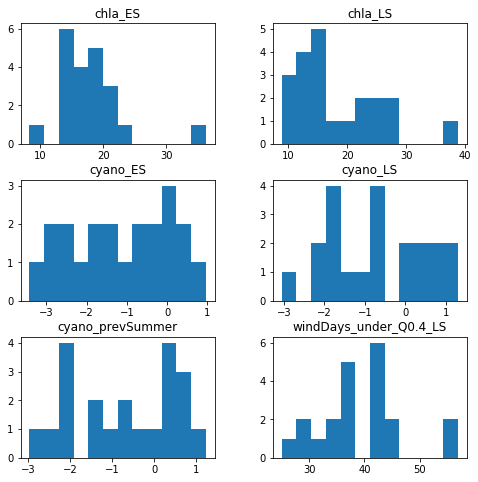

In [137]:
# Copy original df
cont_df_cyano_boxcx = cont_df_cyano.copy()

# Apply transformation 
for col in ['cyano_ES','cyano_LS', 'cyano_prevSummer']:
    cont_df_cyano_boxcx[col] = boxcox(cont_df_cyano[col].values, lmbda=0.1)

cont_df_cyano_boxcx.to_csv(r'../../data/DataMatrices/Vansjo_Seasonal_Continuous_cyano_boxcox.csv')

# Plot histogram again
axes = cont_df_cyano_boxcx.hist(bins=12, figsize=(8,8), grid=False)

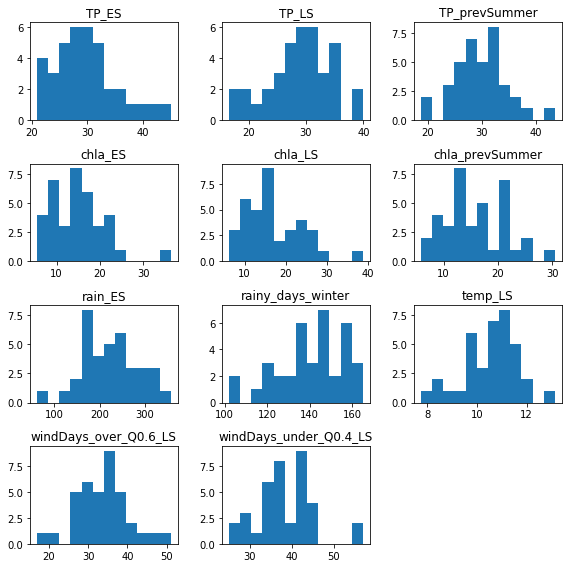

In [139]:
axes = cont_df_noCyano.hist(bins=12, figsize=(8,8), grid=False)
plt.tight_layout()